### MFCC Acoustic Extraction Pipeline

In [ ]:
import math
from math import log
import numpy as np
from scipy.io import wavfile
from scipy.signal import hamming
from scipy.fft import fft
import matplotlib.pyplot as plt
from matplotlib import cm

In [ ]:
def compute_mfcc(wlength, wshift):

    # Loading the Audio File:
    samplerate, data = wavfile.read('signal.wav')
    length = data.shape[0] / samplerate
    print("sample rate: ", samplerate, "\nsamples:", data.shape[0], "\nlength:", length, "seconds")

    # Mean Subtraction:
    subtracted = data - np.mean(data)

    # Compute Pre-Emphasis:
    pre_emphasis = subtracted - (0.97 * np.concatenate(([0],subtracted[:-1])))

    # Compute Frames:
    frame_count = math.ceil((pre_emphasis.shape[0] - wlength) / wshift)
    frames = []
    for i in range (frame_count):
        frame = pre_emphasis[i*wshift:i*wshift+wlength]
        frames.append(frame)
    last_frame = pre_emphasis[frame_count * wshift:]
    last_frame = np.append(last_frame, [0] * (wlength-last_frame.shape[0]))
    frames.append(last_frame)
    frames = np.array(frames)

    # Apply window function:
    ham = [hamming(wlength)] * frames.shape[0]
    applied = np.multiply(frames, ham)

    # Compute FT:
    ft_list = fft(applied, 512)

    # Compute power spectrums:
    power_spectrum = np.abs(ft_list) * np.abs(ft_list)

    # Read in mel-filter:
    mel_filters = np.load("mel_filters.npy")
    plt.plot(mel_filters.T)
    plt.title("Mel-Filterbanks Plot")
    plt.show()
    
    # Computer mels:
    mel_list = []
    for spectra in power_spectrum:
        mel = []
        for i in range(23):
            sum = 0
            for j in range(257):
                sum += mel_filters[i][j] * spectra[j]
            mel.append(sum)
        mel_list.append(mel)
    mel_list = np.array(mel_list)

    # Compute log of mels:
    mel_log = np.maximum(np.full(shape=mel_list.shape, fill_value=-50, dtype=int), np.log(mel_list))

    # Compute dct and liftering:
    dct_list = []
    for mel in mel_log:
        dct_coef = []
        for i in range(13):
            sum = 0
            for j in range(23):
                sum += mel[j] * math.cos((math.pi * i/23) * (j+0.5))
            dct_coef.append(sum)
        dct_list.append(dct_coef)
    dct_list = np.array(dct_list)

    # Plotting mfcc:
    dct_plot = dct_list.T[1:]
    plt.imshow(dct_plot, aspect='auto', origin='lower', interpolation='none')
    plt.title("MFCC")
    plt.xlabel("Frames")
    plt.ylabel("Cepstral Coefficients")
    plt.colorbar()
    plt.show()
    return (frames, applied, ft_list, power_spectrum, mel_list, mel_log, dct_list.T)

**What is the sampling rate of the audio, and how many samples are in the recording? How many seconds worth of audio does this correspond to?**

The sampling rate is 16000 samples/second.
There are 18091 samples.
The length of the audio clip is 1.1306875 seconds.

sample rate:  16000 
samples: 18091 
length: 1.1306875 seconds


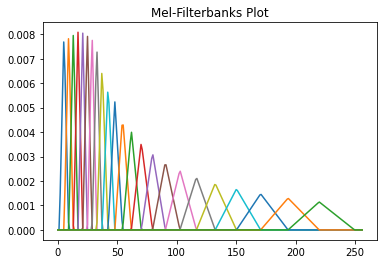

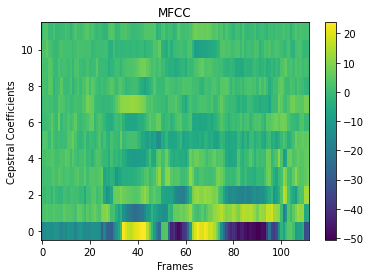

In [ ]:
# Putting it all together:
mfcc = compute_mfcc(400, 160)
mfcc_long = mfcc    

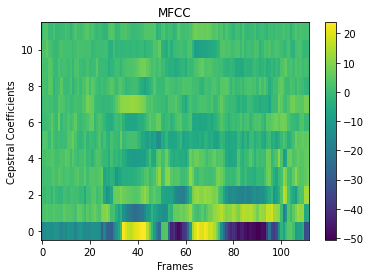

In [ ]:
# Compare with reference mfcc:
ref_mfcc = np.load("reference_mfcc.npy")
plt.imshow(ref_mfcc.T[1:], aspect='auto', origin='lower', interpolation='none')
plt.title("MFCC")
plt.xlabel("Frames")
plt.ylabel("Cepstral Coefficients")
plt.colorbar()
plt.show()

**What is the Mean Squared Error (MSE) between the two matrices?**

The mean squared error is 2.0949436642308737e-26.

mean squared error: 2.0949436642308737e-26


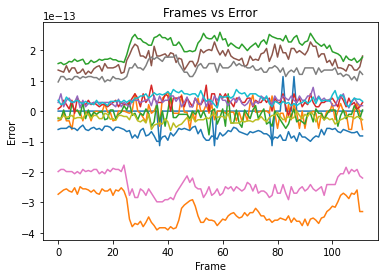

In [ ]:
# Computer mse:
error = ref_mfcc - mfcc[-1].T
print('mean squared error:', np.mean(np.square(error)))
plt.plot(error)
plt.title("Frames vs Error")
plt.xlabel("Frame")
plt.ylabel("Error")
plt.show()

**Comment on how these two spectra look different:**
The Mel-Filterbanks Logs vs Frames graph shows less noise and more clear formants and banding as a result of having more clear data due to the filtering of such noise using the Mel-Filterbanks data.

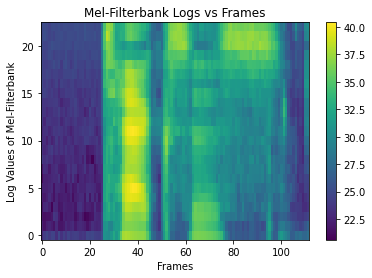

In [ ]:
# Plot Logs of Mel-Filterbank Values:
plt.imshow(mfcc[-2].T, aspect='auto', origin='lower', interpolation='none')
plt.title("Mel-Filterbank Logs vs Frames")
plt.xlabel("Frames")
plt.ylabel("Log Values of Mel-Filterbank")
plt.colorbar()
plt.show()

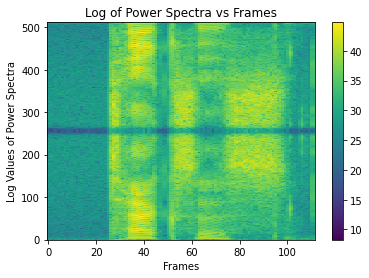

In [ ]:
# Plot Logs of Power Spectra:
pow_log = np.maximum(np.full(shape=mfcc[3].shape, fill_value=-50, dtype=int), np.log(mfcc[3]))
plt.imshow(pow_log.T, aspect='auto', origin='lower', interpolation='none')
plt.colorbar()
plt.title("Log of Power Spectra vs Frames")
plt.xlabel("Frames")
plt.ylabel("Log Values of Power Spectra")
plt.show()

**How does the spectrum look different when using 25 millisecond windows
as opposed to 4 millisecond windows? Why does this happen?**

As derived from the time-frequency uncertainty principle, the shorter the window length, the better the time frequency and the worse the frequency resolution. This is supported by the graphs as the new graphs below have clearly worse frequency resolution but better time resolution.

sample rate:  16000 
samples: 18091 
length: 1.1306875 seconds


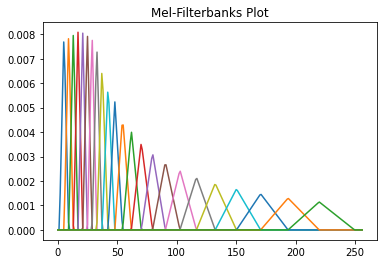

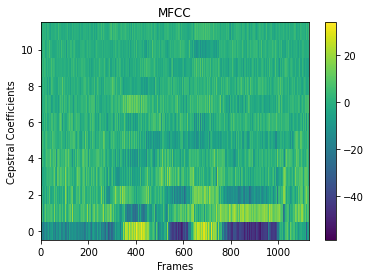

In [ ]:
# Compute Short Window MFCC: 
mfcc = compute_mfcc(64, 16)

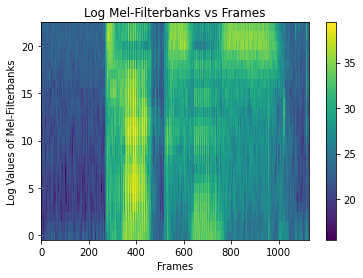

In [ ]:
# Plot Log Mel-Filterbanks Values of Short Window
plt.imshow(mfcc[-2].T, aspect='auto', origin='lower', interpolation='none')
plt.title("Log Mel-Filterbanks vs Frames")
plt.xlabel("Frames")
plt.ylabel("Log Values of Mel-Filterbanks")
plt.colorbar()
plt.show()

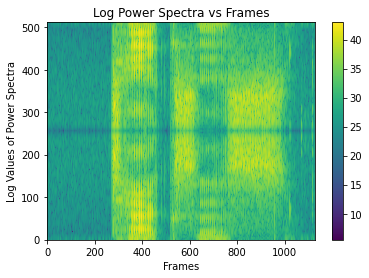

In [ ]:
# Plot Log of Power Spectra of Short Window
pow_log = np.maximum(np.full(shape=mfcc[3].shape, fill_value=-50, dtype=int), np.log(mfcc[3]))
plt.imshow(pow_log.T, aspect='auto', origin='lower', interpolation='none')
plt.title("Log Power Spectra vs Frames")
plt.xlabel("Frames")
plt.ylabel("Log Values of Power Spectra")
plt.colorbar()
plt.show()

**What do you notice about the value that 𝐶1 takes on during a vowel vs. during a fricative? Why is this the case?**

With certain fricatives and vowels, C1 is emphasized with higher energy shown. Specifically, when emphasizing the fricatives t and k in teksas, there are peaks in the energy graph while other areas seem to fall down. Since the syllables start with the fricatives, more energy is released there which leads to higher C1 values. The only exception here is e which also has a fairly high C1 despite being a vowel due to it also being emphasized at the beginning of the word.

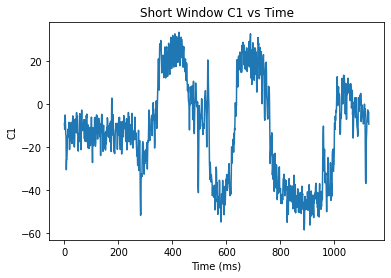

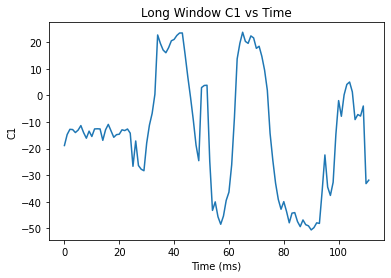

In [ ]:
# Plot Short Window C1
plt.plot(mfcc[-1][1])
plt.title("Short Window C1 vs Time")
plt.xlabel('Time (ms)')
plt.ylabel('C1')
plt.show()
# Plot Long Window C1
plt.plot(mfcc_long[-1][1])
plt.title("Long Window C1 vs Time")
plt.xlabel("Time (ms)")
plt.ylabel("C1")
plt.show()